# <center>Using SQLite for a data warehouse</center>

### Author:  Bryan Cafferky  - For Demonstration Purposes Only

### Not intended for production use. 

## Documentation at: https://docs.python.org/3/library/sqlite3.html

# Create or Point to Our SQLite database...

### 1)  Load the SQLite package...

In [2]:
import sqlite3

print(sqlite3.version)
print(sqlite3.sqlite_version)

2.6.0
3.34.0


### 2) Connect to the database.  

In [3]:
slconn = sqlite3.connect('aw_eda.db') # permanent database

In [4]:
print(slconn)

### 3)  Create a cursor to execute statements to SQLite.

In [5]:
cursor = slconn.cursor()

In [6]:
cursor

# Get Data from database management systems...

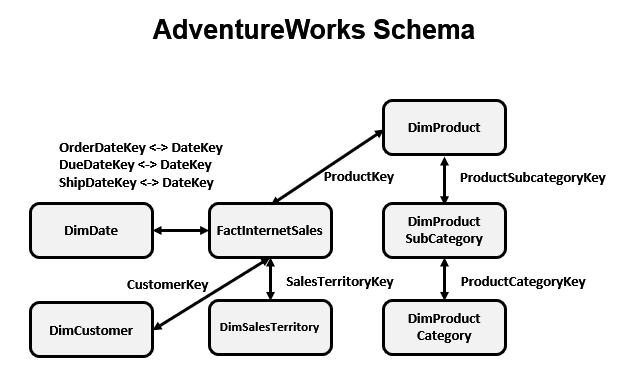

### Load our simple SQLDB class from dbutils module...

In [10]:
from dbutils.dbaccess import SQLDB

### Define the SQL Server name...

In [44]:
sqlservername = 'DESKTOP-C3IP93F' # este es el nombre de mi servidor

### Create a SQL query to execute...

### Create the SQLDB object pointing to the SQL Server...

#### We only need to override the constructor parameters that differ from what we need.
#### Below we use the default of integrated security.
#### Parameters: Server, Integrated Security (True/False), Driver, Database

In [45]:
# 1er parametro = nombre del servidor, 2do paranetro = True, 3er parametro = nombre del driver, 4to parametro = nombre de base de datos
# dentro de la variable aw_sql_is se crea la instancia u objeto de la clase SQLDB
aw_sql_is = SQLDB(sqlservername, True, '{SQL Server}', 'AdventureWorks2017')
# este driver no funciono: ODBC Driver 13 for SQL Server


#### Once the SQLDB object is created, you can run queries with just the SQL statement.
#### It stores the connection string information in the object instance. 

##### Directly run the query...

In [46]:
# se usa la funcion o metodo get_db_data creada dentro de la clase SQLDB creado como un Modulo
aw_sql_is.get_db_data('select top 2 * from Sales.Store')


,BusinessEntityID,Name,SalesPersonID,Demographics,rowguid,ModifiedDate
0,292,Next-Door Bike Store,279,"<StoreSurvey xmlns=""http://schemas.microsoft.c...",A22517E3-848D-4EBE-B9D9-7437F3432304,2014-09-12 11:15:07.497
1,294,Professional Sales and Service,276,"<StoreSurvey xmlns=""http://schemas.microsoft.c...",B50CA50B-C601-4A13-B07E-2C63862D71B4,2014-09-12 11:15:07.497


##### Or store the query results to a dataframe...

In [49]:
# se usa la funcion o metodo get_db_data creada dentro de la clase SQLDB creado como un Modulo
dfproduct = aw_sql_is.get_db_data('SELECT TOP 5 * from Sales.Store')
dfproduct.head()

,BusinessEntityID,Name,SalesPersonID,Demographics,rowguid,ModifiedDate
0,292,Next-Door Bike Store,279,"<StoreSurvey xmlns=""http://schemas.microsoft.c...",A22517E3-848D-4EBE-B9D9-7437F3432304,2014-09-12 11:15:07.497
1,294,Professional Sales and Service,276,"<StoreSurvey xmlns=""http://schemas.microsoft.c...",B50CA50B-C601-4A13-B07E-2C63862D71B4,2014-09-12 11:15:07.497
2,296,Riders Company,277,"<StoreSurvey xmlns=""http://schemas.microsoft.c...",337C3688-1339-4E1A-A08A-B54B23566E49,2014-09-12 11:15:07.497
3,298,The Bike Mechanics,275,"<StoreSurvey xmlns=""http://schemas.microsoft.c...",7894F278-F0C8-4D16-BD75-213FDBF13023,2014-09-12 11:15:07.497
4,300,Nationwide Supply,286,"<StoreSurvey xmlns=""http://schemas.microsoft.c...",C3FC9705-A8C4-4F3A-9550-EB2FA4B7B64D,2014-09-12 11:15:07.497


#### Create another SQLDB object that uses SQL Server Security.

In [55]:
aw_sql_sqlsec = SQLDB(sqlservername, 
                False, '{SQL Server}', 
                'AdventureWorks2017',  
                'Bryan',  # username falso
                'bryan')  # password falso

In [56]:
aw_sql_sqlsec.get_db_data('select top 2 * from Sales.Store').head(3)

,BusinessEntityID,Name,SalesPersonID,Demographics,rowguid,ModifiedDate
0,292,Next-Door Bike Store,279,"<StoreSurvey xmlns=""http://schemas.microsoft.c...",A22517E3-848D-4EBE-B9D9-7437F3432304,2014-09-12 11:15:07.497
1,294,Professional Sales and Service,276,"<StoreSurvey xmlns=""http://schemas.microsoft.c...",B50CA50B-C601-4A13-B07E-2C63862D71B4,2014-09-12 11:15:07.497


### We can create a SQLDB object that points to any type of database with an ODBC driver. Below we connect to a PostgreSQL database.

### Podemos crear un objeto SQLDB que apunte a cualquier tipo de base de datos con un controlador ODBC. A continuación nos conectamos a una base de datos PostgreSQL.

In [141]:
aw_postgresdb = SQLDB('localhost', True, '{PostgreSQL Unicode(x64)}', 'dvdrental', 'fulanito', 'fulanito')
# driver = PostgreSQL ODBC Driver(UNICODE)


In [142]:
aw_postgresdb.get_db_data('select * from city limit 10')

InterfaceError: ('IM003', '[IM003] No se puede cargar el controlador especificado debido al error del sistema  126: No se puede encontrar el módulo especificado. (PostgreSQL Unicode(x64), C:\\Program Files\\Tableau\\Drivers\\psqlODBC\\0906\\bin\\psqlodbc35w.dll). (160) (SQLDriverConnect)')

## Let's extract data from the backend databases, and do some data munging to add value. 

## Extraigamos los datos de las bases de datos del backend, y hagamos algo de munición de datos para añadir valor.

## We are building a local data warehouse to persist the data.

## Estamos construyendo un almacén de datos local para persistir los datos.

### Get data from SQL Server...
#### Notice:  We are pushing the work to SQL Server and just getting the result.

#### Aviso:  Estamos empujando el trabajo a SQL Server y sólo obtenemos el resultado.

In [143]:
sql = '''
SELECT EnglishProductCategoryName as Category,
      sc.EnglishProductSubcategoryName as SubCat,
      p.EnglishProductName as Product,
      SUM(SalesAmount) as SalesAmount
FROM dbo.FactInternetSales          s
JOIN  dbo.DimProduct                p
  on (s.ProductKey = p.ProductKey) 
JOIN dbo.DimProductSubcategory      sc
  ON (p.ProductSubcategoryKey = sc.ProductSubcategoryKey)
JOIN dbo.DimProductCategory         pc
  ON (sc.ProductCategoryKey = pc.ProductCategoryKey)
GROUP BY EnglishProductCategoryName, 
      EnglishProductSubcategoryName,
      EnglishProductName
'''

### Create another SQLDB Object

In [145]:
aw_sql_third = SQLDB(sqlservername, 
                False, '{SQL Server}', 
                'AdventureWorksDW2017',  
                'Bryan',  # username falso
                'bryan')  # password falso

In [146]:
salessummarydf = aw_sql_third.get_db_data(sql)
salessummarydf

,Category,SubCat,Product,SalesAmount
0,Accessories,Bike Racks,Hitch Rack - 4-Bike,39360.00
1,Accessories,Bike Stands,All-Purpose Bike Stand,39591.00
2,Accessories,Bottles and Cages,Mountain Bottle Cage,20229.75
3,Accessories,Bottles and Cages,Road Bottle Cage,15390.88
4,Accessories,Bottles and Cages,Water Bottle - 30 oz.,21177.56
...,...,...,...,...
125,Clothing,Socks,"Racing Socks, L",2427.30
126,Clothing,Socks,"Racing Socks, M",2679.02
127,Clothing,Vests,"Classic Vest, L",12382.50
128,Clothing,Vests,"Classic Vest, M",12636.50


In [147]:
# Store the results in our SQLite data warehouse

# if_exists options are replace, append, 
salessummarydf.to_sql('internetsalessummary', con=slconn, index=False, if_exists='replace')

#### Getting meta data...

In [148]:
salessummarydf.columns 

Index(['Category', 'SubCat', 'Product', 'SalesAmount'], dtype='object')

In [149]:
salessummarydf.dtypes

Category        object
SubCat          object
Product         object
SalesAmount    float64
dtype: object

In [150]:
# Get table schema...
import pandas as pd 

pd.read_sql_query("""
PRAGMA table_info('internetsalessummary');
""", slconn)

,cid,name,type,notnull,dflt_value,pk
0,0,Category,TEXT,0,None,0
1,1,SubCat,TEXT,0,None,0
2,2,Product,TEXT,0,None,0
3,3,SalesAmount,REAL,0,None,0


### Querying data in SQLite...

In [151]:
import sqlite3
import pandas as pd

pd.read_sql_query("SELECT * FROM internetsalessummary", slconn).head(4)

,Category,SubCat,Product,SalesAmount
0,Accessories,Bike Racks,Hitch Rack - 4-Bike,39360.00
1,Accessories,Bike Stands,All-Purpose Bike Stand,39591.00
2,Accessories,Bottles and Cages,Mountain Bottle Cage,20229.75
3,Accessories,Bottles and Cages,Road Bottle Cage,15390.88


In [152]:
#  Note the round(2) function to elimiate scientific notation in pandas...
#  Observe la función round(2) para eliminar la notación científica en pandas...

#  index_col=['Category'] to eliminate the df index 
#  index_col=['Categoría'] para eliminar el índice df

pd.read_sql_query('''
SELECT Category, sum(SalesAmount) as Sales  
FROM internetsalessummary
GROUP BY Category''', slconn, index_col=['Category']).round(2)


,Sales
Category,
Accessories,700759.96
Bikes,28318144.65
Clothing,339772.61


### We want to build some dimension tables but let's think about it first...

### Queremos construir algunas tablas de dimensiones pero primero pensemos en ello...

In [153]:
# We just need to pass in the query string.  The connection properties are already set.
# Sólo tenemos que pasar la cadena de consulta.  Las propiedades de conexión ya están establecidas.
aw_sql_third.get_db_data('''
SELECT * 
FROM dimproductcategory''').head(2)


,ProductCategoryKey,ProductCategoryAlternateKey,EnglishProductCategoryName,SpanishProductCategoryName,FrenchProductCategoryName
0,1,1,Bikes,Bicicleta,Vélo
1,2,2,Components,Componente,Composant


In [154]:
aw_sql_third.get_db_data('''
SELECT ProductKey, ProductSubCategoryKey, EnglishProductName as Name, Status 
FROM dimproduct''').head(2)

,ProductKey,ProductSubCategoryKey,Name,Status
0,1,NaN,Adjustable Race,Current
1,2,NaN,Bearing Ball,Current


### Let's download the Product Dimension tables as a single SQLite table.

### Descarguemos las tablas de la dimensión del producto como una única tabla SQLite.

In [155]:
sql = '''
SELECT  
    p.ProductKey, s.ProductSubcategoryKey, c.ProductCategoryKey, 
    EnglishProductCategoryName as Category, 
    EnglishProductSubcategoryName as Subcategory, ModelName as Model
FROM
    dimproduct                   p
INNER JOIN  
    dimproductsubcategory        s
ON 
    (p.ProductSubcategoryKey = s.ProductSubcategoryKey)
INNER JOIN 
    dimproductcategory           c
ON 
    (s.ProductCategoryKey = c.ProductCategoryKey)
WHERE 
    p.Status = 'Current' OR p.Status = 'NULL' 
'''

In [157]:
aw_sql_third.get_db_data(sql)#.head(3)

,ProductKey,ProductSubcategoryKey,ProductCategoryKey,Category,Subcategory,Model
0,210,14,2,Components,Road Frames,HL Road Frame
1,211,14,2,Components,Road Frames,HL Road Frame
2,214,31,4,Accessories,Helmets,Sport-100
3,217,31,4,Accessories,Helmets,Sport-100
4,222,31,4,Accessories,Helmets,Sport-100
...,...,...,...,...,...,...
192,602,5,2,Components,Bottom Brackets,ML Bottom Bracket
193,603,5,2,Components,Bottom Brackets,HL Bottom Bracket
194,604,2,1,Bikes,Road Bikes,Road-750
195,605,2,1,Bikes,Road Bikes,Road-750


### the to_sql() dataframe method will save the data to our SQLite database.

### el método to_sql() dataframe guardará los datos en nuestra base de datos SQLite.

In [158]:
# if_exists has 3 options: replace, append, fail
# if_exists tiene 3 opciones: replace, append, fail

aw_sql_third.get_db_data(sql).to_sql('dimproduct', con=slconn, index=False, if_exists='replace')


In [159]:
# Let's confirm the table is there...
import sqlite3
import pandas as pd

pd.read_sql_query("SELECT * FROM dimproduct limit 3", slconn).head(3)

,ProductKey,ProductSubcategoryKey,ProductCategoryKey,Category,Subcategory,Model
0,210,14,2,Components,Road Frames,HL Road Frame
1,211,14,2,Components,Road Frames,HL Road Frame
2,214,31,4,Accessories,Helmets,Sport-100


### What other data do we want?

### ¿Qué otros datos queremos?

In [160]:
aw_sql_third.get_db_data('''select top 1 * from factinternetsales''')

,ProductKey,OrderDateKey,DueDateKey,ShipDateKey,CustomerKey,PromotionKey,CurrencyKey,SalesTerritoryKey,SalesOrderNumber,SalesOrderLineNumber,...,ProductStandardCost,TotalProductCost,SalesAmount,TaxAmt,Freight,CarrierTrackingNumber,CustomerPONumber,OrderDate,DueDate,ShipDate
0,310,20101229,20110110,20110105,21768,1,19,6,SO43697,1,...,2171.2942,2171.2942,3578.27,286.2616,89.4568,None,None,2010-12-29,2011-01-10,2011-01-05


In [161]:
# \ me permite extender el comando a una linea nueva
aw_sql_third.get_db_data('select * from factinternetsales'). \
to_sql('factinternetsales', con=slconn, index=False, if_exists='replace')

In [162]:
pd.read_sql_query("SELECT * FROM factinternetsales limit 3", slconn)

,ProductKey,OrderDateKey,DueDateKey,ShipDateKey,CustomerKey,PromotionKey,CurrencyKey,SalesTerritoryKey,SalesOrderNumber,SalesOrderLineNumber,...,ProductStandardCost,TotalProductCost,SalesAmount,TaxAmt,Freight,CarrierTrackingNumber,CustomerPONumber,OrderDate,DueDate,ShipDate
0,310,20101229,20110110,20110105,21768,1,19,6,SO43697,1,...,2171.2942,2171.2942,3578.27,286.2616,89.4568,None,None,2010-12-29 00:00:00,2011-01-10 00:00:00,2011-01-05 00:00:00
1,346,20101229,20110110,20110105,28389,1,39,7,SO43698,1,...,1912.1544,1912.1544,3399.99,271.9992,84.9998,None,None,2010-12-29 00:00:00,2011-01-10 00:00:00,2011-01-05 00:00:00
2,346,20101229,20110110,20110105,25863,1,100,1,SO43699,1,...,1912.1544,1912.1544,3399.99,271.9992,84.9998,None,None,2010-12-29 00:00:00,2011-01-10 00:00:00,2011-01-05 00:00:00


In [163]:
aw_sql_third.get_db_data('select * from dimcustomer'). \
to_sql('dimcustomer', con=slconn, index=False, if_exists='replace')

In [165]:
aw_sql_third.get_db_data('select * from dimdate'). \
to_sql('dimdate', con=slconn, index=False, if_exists='replace')

### Create a SQLite view that pulls all the data together...
### Crear una vista SQLite que reúna todos los datos...

##### Note the 'if not exists' - so you don't get an error on reruns...
##### Tenga en cuenta el "si no existe" - para que no se produzca un error en las repeticiones...

In [166]:
sql = '''
CREATE VIEW IF NOT EXISTS v_salesinfo as  
SELECT  
    OrderDateKey, DueDateKey, s.CustomerKey, SalesTerritoryKey,
    SalesAmount, p.*, Gender, YearlyIncome as Salary, OrderQuantity, TotalProductCost, TaxAmt, 
CASE WHEN 
    NumberChildrenAtHome > 0 THEN 'Y' 
    ELSE 'N' 
    END 
    as HasChildren, 
    c.EnglishEducation as Education, 
    c.CommuteDistance,
    c.BirthDate, 
CAST( ((JulianDay('now')) - JulianDay(BirthDate))/365.2 as int) as Age,
d.FiscalYear, d.FiscalQuarter, d.EnglishMonthName as Month, MonthNumberOfYear, d.CalendarYear
FROM 
    factinternetsales          s
INNER JOIN 
    dimcustomer                c
ON 
    (s.CustomerKey = c.CustomerKey)
INNER JOIN 
    dimproduct                 p
ON 
    (s.ProductKey = p.ProductKey)
INNER JOIN 
    dimdate                    d
ON 
    (s.OrderDateKey = d.DateKey);
'''

In [167]:
# We created the cursor to the SQLite database at the beginning.

cursor.execute(sql)

In [168]:
pd.read_sql_query('select * from v_salesinfo', slconn).head(3)

,OrderDateKey,DueDateKey,CustomerKey,SalesTerritoryKey,SalesAmount,ProductKey,ProductSubcategoryKey,ProductCategoryKey,Category,Subcategory,...,HasChildren,Education,CommuteDistance,BirthDate,Age,FiscalYear,FiscalQuarter,Month,MonthNumberOfYear,CalendarYear
0,20121228,20130109,18239,9,2443.35,380,2,1,Bikes,Road Bikes,...,N,Graduate Degree,0-1 Miles,1980-07-19,41,2012,2,December,12,2012
1,20121228,20130109,18239,9,8.99,479,28,4,Accessories,Bottles and Cages,...,N,Graduate Degree,0-1 Miles,1980-07-19,41,2012,2,December,12,2012
2,20121228,20130109,27873,9,1214.85,577,3,1,Bikes,Touring Bikes,...,N,Bachelors,0-1 Miles,1983-10-01,38,2012,2,December,12,2012


### Load CSV file into our SQLite database...

In [169]:
salesterritory = pd.read_csv('.\data\dimsalesterritory.csv')  
salesterritory.head(2)

,SalesTerritoryKey,SalesTerritoryAlternateKey,SalesTerritoryRegion,SalesTerritoryCountry,SalesTerritoryGroup,SalesTerritoryImage
0,1,1,Northwest,United States,North America,0xFFD8FFE000104A46494600010101004800480000FFDB...
1,2,2,Northeast,United States,North America,0xFFD8FFE000104A46494600010101004800480000FFDB...


In [170]:
salesterritory.to_sql('dimsalesterritory', con=slconn, index=False, if_exists='replace')

In [171]:
sql = '''
SELECT 
    t.SalesTerritoryCountry, t.SalesTerritoryRegion, SUM(SalesAmount)
FROM  
    FactInternetSales   s
JOIN  
    DimSalesTerritory   t
ON 
    (s.SalesTerritoryKey = t.SalesTerritoryKey)
GROUP BY 
    SalesTerritoryCountry, SalesTerritoryRegion
ORDER BY
    SUM(SalesAmount) DESC
'''

In [172]:
pd.read_sql_query(sql, slconn, index_col=['SalesTerritoryCountry']).round(2)

,SalesTerritoryRegion,SUM(SalesAmount)
SalesTerritoryCountry,,
Australia,Australia,9061000.58
United States,Southwest,5718150.81
United States,Northwest,3649866.55
United Kingdom,United Kingdom,3391712.21
Germany,Germany,2894312.34
France,France,2644017.71
Canada,Canada,1977844.86
United States,Southeast,12238.85
United States,Northeast,6532.47


## Let's bring in some data from a PostgreSQL database...
##### This is a retail customer list maintained in a different system and we want to analyze this data.

In [173]:
retail_cust_pg_df = aw_postgresdb.get_db_data('select * from dimcustomer')

InterfaceError: ('IM003', '[IM003] No se puede cargar el controlador especificado debido al error del sistema  126: No se puede encontrar el módulo especificado. (PostgreSQL Unicode(x64), C:\\Program Files\\Tableau\\Drivers\\psqlODBC\\0906\\bin\\psqlodbc35w.dll). (160) (SQLDriverConnect)')

In [64]:
retail_cust_pg_df.to_sql('dimretailcustomers', con=slconn, index=False, if_exists='replace')

In [65]:
pd.read_sql_query('select * from dimretailcustomers limit 3', slconn)

,CustomerKey,GeographyKey,CustomerAlternateKey,Title,FirstName,MiddleName,LastName,NameStyle,BirthDate,MaritalStatus,...,EnglishOccupation,SpanishOccupation,FrenchOccupation,HouseOwnerFlag,NumberCarsOwned,AddressLine1,AddressLine2,Phone,DateFirstPurchase,CommuteDistance
0,11000,26,AW00011000,None,Jon,V,Yang,0,1971-10-06,M,...,Professional,Profesional,Cadre,1,0,3761 N. 14th St,None,1 (11) 500 555-0162,2011-01-19,1-2 Miles
1,11001,37,AW00011001,None,Eugene,L,Huang,0,1976-05-10,S,...,Professional,Profesional,Cadre,0,1,2243 W St.,None,1 (11) 500 555-0110,2011-01-15,0-1 Miles
2,11002,31,AW00011002,None,Ruben,None,Torres,0,1971-02-09,M,...,Professional,Profesional,Cadre,1,1,5844 Linden Land,None,1 (11) 500 555-0184,2011-01-07,2-5 Miles


## We can drop the table since we are done.

## Podemos eliminar la tabla ya que hemos terminado.

In [66]:
cursor.execute('''select * from internetsalessummary limit 5;''').fetchall()

[('Accessories', 'Bike Racks', 'Hitch Rack - 4-Bike', 39360.0),
 ('Accessories', 'Bike Stands', 'All-Purpose Bike Stand', 39591.0),
 ('Accessories', 'Bottles and Cages', 'Mountain Bottle Cage', 20229.75),
 ('Accessories', 'Bottles and Cages', 'Road Bottle Cage', 15390.88),
 ('Accessories', 'Bottles and Cages', 'Water Bottle - 30 oz.', 21177.56)]

In [67]:
cursor.execute('''DROP TABLE internetsalessummary''')
slconn.commit()

In [68]:
cursor.execute('''select * from internetsalessummary;''').fetchall()

OperationalError: no such table: internetsalessummary

# Let's close the connection. 

In [69]:
cursor.close()
slconn.close()